In [1]:
import xarray as xr
import numpy as np
from distributed import Client
import logging
import flox  # make sure its available
import flox.xarray
from tqdm.contrib.itertools import product
from tqdm.notebook import tqdm
# client = Client(n_workers=20, silence_logs=logging.ERROR)
# client

In [2]:
era5 = xr.open_zarr(
    'gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3',
    chunks={'time': 50, 'latitude': 721, 'longitude': 1440},
    storage_options=dict(token='anon'),
)

In [3]:
era5_85th_climatology =  xr.open_zarr('/home/taylor/data/era5_2m_temperature_85th_by_hour_dayofyear.zarr')

In [4]:
ds_list = []
window_days = 5
weights = np.linspace(0,1, window_days * 2 + 1)
weights = np.concatenate([weights, weights[::-1][1:]])
weights /= weights.sum()
for hr in era5_85th_climatology.hour:
    subset = era5_85th_climatology['2m_temperature'].sel(hour=hr).compute()
    subset = subset.pad(dayofyear=(10, 11), mode='wrap')
    new_dayofyear = xr.DataArray(np.arange(-10, 377), dims='dayofyear')
    subset = subset.assign_coords(dayofyear=new_dayofyear)
    subset = subset.rolling(dayofyear=21, center=True).construct('window').dot(xr.DataArray(weights, dims='window')).expand_dims(hour=[hr])
    subset = subset.sel(dayofyear=slice(1, 366))
    ds_list.append(subset)

In [5]:
rolling_85th_climatology = xr.concat(ds_list,dim='hour')
rolling_85th_climatology= rolling_85th_climatology.to_dataset(name='surface_temperature_85th_percentile')
rolling_85th_climatology_2021 = utils.convert_day_yearofday_to_time(
        rolling_85th_climatology, 2021
    )

In [ ]:
rolling_85th_climatology

<xarray.Dataset> Size: 12GB
Dimensions:                              (hour: 4, latitude: 721,
                                          longitude: 1440, dayofyear: 366)
Coordinates:
  * hour                                 (hour) int64 32B 0 6 12 18
  * latitude                             (latitude) float32 3kB 90.0 ... -90.0
  * longitude                            (longitude) float32 6kB 0.0 ... 359.8
    quantile                             float64 8B 0.85
  * dayofyear                            (dayofyear) int64 3kB 1 2 3 ... 365 366
Data variables:
    surface_temperature_85th_percentile  (hour, latitude, longitude, dayofyear) float64 12GB ...

In [5]:
rolling_85th_climatology.to_zarr('/home/taylor/data/era5_2m_temperature_85th_rolling_by_hour_dayofyear.zarr', mode='w')

In [8]:
xr.open_zarr('/home/taylor/data/era5_2m_temperature_85th_rolling_by_hour_dayofyear.zarr')

<xarray.Dataset> Size: 12GB
Dimensions:                              (dayofyear: 366, hour: 4,
                                          latitude: 721, longitude: 1440)
Coordinates:
  * dayofyear                            (dayofyear) int64 3kB 1 2 3 ... 365 366
  * hour                                 (hour) int64 32B 0 6 12 18
  * latitude                             (latitude) float32 3kB 90.0 ... -90.0
  * longitude                            (longitude) float32 6kB 0.0 ... 359.8
    quantile                             float64 8B ...
Data variables:
    surface_temperature_85th_percentile  (hour, latitude, longitude, dayofyear) float64 12GB dask.array<chunksize=(1, 91, 180, 46), meta=np.ndarray>

In [89]:
output_climatology = utils.convert_day_yearofday_to_time(era5_85th_climatology,2021)

<xarray.Dataset> Size: 12GB
Dimensions:         (latitude: 721, longitude: 1440, time: 1464)
Coordinates:
  * latitude        (latitude) float32 3kB 90.0 89.75 89.5 ... -89.75 -90.0
  * longitude       (longitude) float32 6kB 0.0 0.25 0.5 ... 359.2 359.5 359.8
    quantile        float64 8B ...
  * time            (time) datetime64[ns] 12kB 2021-01-01 ... 2022-01-01T18:0...
Data variables:
    2m_temperature  (latitude, longitude, time) float64 12GB dask.array<chunksize=(721, 1440, 1), meta=np.ndarray>

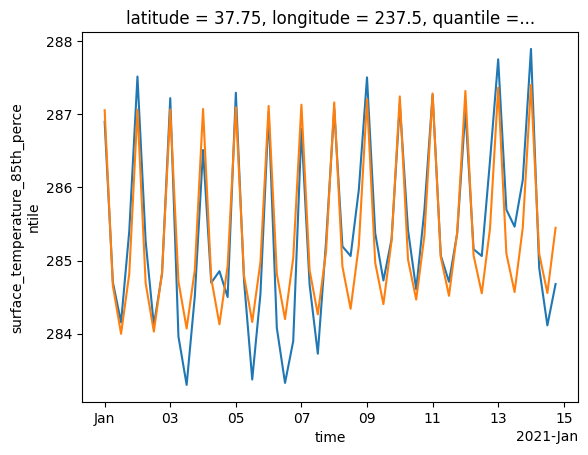

In [88]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
utils.convert_day_yearofday_to_time(era5_85th_climatology,2021).sel(time=slice('2021-01-01', '2021-01-14'))['2m_temperature'].sel(latitude=37.7749, longitude=np.mod(-122.4194,360),method='nearest').plot(ax=ax)
rolling_85th_climatology_2021.sel(time=slice('2021-01-01', '2021-01-14'))['surface_temperature_85th_percentile'].sel(latitude=37.7749, longitude=np.mod(-122.4194,360),method='nearest').plot(ax=ax)

In [6]:
# Select the time range
era5_30yr = era5.sel(time=slice('1990-01-01', '2020-12-31'))
era5_30yr = era5_30yr.sel(time=era5_30yr['time'].to_index().isin(pd.date_range('1990-01-01', '2020-12-31', freq='6H')))
era5_30yr

/tmp/ipykernel_38471/1941399339.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  era5_30yr = era5_30yr.sel(time=era5_30yr['time'].to_index().isin(pd.date_range('1990-01-01', '2020-12-31', freq='6H')))


<xarray.Dataset> Size: 126TB
Dimensions:                                                          (
                                                                      time: 45289,
                                                                      latitude: 721,
                                                                      longitude: 1440,
                                                                      level: 37)
Coordinates:
  * latitude                                                         (latitude) float32 3kB ...
  * level                                                            (level) int64 296B ...
  * longitude                                                        (longitude) float32 6kB ...
  * time                                                             (time) datetime64[ns] 362kB ...
Data variables: (12/273)
    100m_u_component_of_wind                                         (time, latitude, longitude) float32 188GB dask.array<chunksize=(49, 721, 1440), meta=np.ndarray>
    100m_v_component_of_wind                                         (time, latitude, longitude) float32 188GB dask.array<chunksize=(49, 721, 1440), meta=np.ndarray>
    10m_u_component_of_neutral_wind                                  (time, latitude, longitude) float32 188GB dask.array<chunksize=(49, 721, 1440), meta=np.ndarray>
    10m_u_component_of_wind                                          (time, latitude, longitude) float32 188GB dask.array<chunksize=(49, 721, 1440), meta=np.ndarray>
    10m_v_component_of_neutral_wind                                  (time, latitude, longitude) float32 188GB dask.array<chunksize=(49, 721, 1440), meta=np.ndarray>
    10m_v_component_of_wind                                          (time, latitude, longitude) float32 188GB dask.array<chunksize=(49, 721, 1440), meta=np.ndarray>
    ...                                                               ...
    wave_spectral_directional_width_for_swell                        (time, latitude, longitude) float32 188GB dask.array<chunksize=(49, 721, 1440), meta=np.ndarray>
    wave_spectral_directional_width_for_wind_waves                   (time, latitude, longitude) float32 188GB dask.array<chunksize=(49, 721, 1440), meta=np.ndarray>
    wave_spectral_kurtosis                                           (time, latitude, longitude) float32 188GB dask.array<chunksize=(49, 721, 1440), meta=np.ndarray>
    wave_spectral_peakedness                                         (time, latitude, longitude) float32 188GB dask.array<chunksize=(49, 721, 1440), meta=np.ndarray>
    wave_spectral_skewness                                           (time, latitude, longitude) float32 188GB dask.array<chunksize=(49, 721, 1440), meta=np.ndarray>
    zero_degree_level                                                (time, latitude, longitude) float32 188GB dask.array<chunksize=(49, 721, 1440), meta=np.ndarray>
Attributes:
    valid_time_start:  1940-01-01
    last_updated:      2024-12-16 19:16:16.959410
    valid_time_stop:   2024-09-30

In [7]:
weights = np.linspace(0,1, 21)
weights = np.concatenate([weights, weights[::-1][1:]])
weights /= weights.sum()
weights

array([0.    , 0.0025, 0.005 , 0.0075, 0.01  , 0.0125, 0.015 , 0.0175,
       0.02  , 0.0225, 0.025 , 0.0275, 0.03  , 0.0325, 0.035 , 0.0375,
       0.04  , 0.0425, 0.045 , 0.0475, 0.05  , 0.0475, 0.045 , 0.0425,
       0.04  , 0.0375, 0.035 , 0.0325, 0.03  , 0.0275, 0.025 , 0.0225,
       0.02  , 0.0175, 0.015 , 0.0125, 0.01  , 0.0075, 0.005 , 0.0025,
       0.    ])

In [7]:
# Define the rolling window parameters
window_days = 10
window_hours = 6
percentile = 85

weights = np.linspace(0,1, window_days * 2 + 1)
weights = np.concatenate([weights, weights[::-1][1:]])
weights /= weights.sum()
weight_da = xr.DataArray(weights, dims=['window'])

era5_30yr_climatology = era5_30yr['2m_temperature'].groupby(['time.dayofyear', 'time.hour']).quantile(0.85)

KeyboardInterrupt: 

2025-01-10 00:36:34,018 - distributed.nanny - ERROR - Worker process died unexpectedly
2025-01-10 00:36:34,021 - distributed.nanny - ERROR - Worker process died unexpectedly
2025-01-10 00:36:34,022 - distributed.nanny - ERROR - Worker process died unexpectedly
2025-01-10 00:36:34,023 - distributed.nanny - ERROR - Worker process died unexpectedly
2025-01-10 00:36:34,041 - distributed.nanny - ERROR - Worker process died unexpectedly
2025-01-10 00:36:34,042 - distributed.nanny - ERROR - Worker process died unexpectedly
2025-01-10 00:36:34,044 - distributed.nanny - ERROR - Worker process died unexpectedly
2025-01-10 00:36:34,065 - distributed.nanny - ERROR - Worker process died unexpectedly
2025-01-10 00:36:34,067 - distributed.nanny - ERROR - Worker process died unexpectedly
2025-01-10 00:36:34,068 - distributed.nanny - ERROR - Worker process died unexpectedly


In [ ]:
era5_30yr_climatology_rolling = era5_30yr_climatology.rolling(time=21, center=True).mean()

In [10]:
# Define the rolling window parameters
window_days = 10
window_hours = 6
percentile = 85

# Create a function to apply the rolling window with linearly decaying weights
def rolling_percentile(data, window_days, window_hours, percentile):
    weights = np.linspace(1, 0, window_days * 2 + 1)
    weights = np.concatenate([weights, weights[::-1][1:]])
    weights /= weights.sum()
    
    def apply_weights(da):
        return (da.rolling(time=window_days*2+1, center=True)
                .construct('window')
                .dot(xr.DataArray(weights, dims='window')))
    
    return (data.groupby('time.dayofyear')
            .map(apply_weights)
            .resample(time=f'{window_hours}H')
            .reduce(np.nanpercentile, q=percentile))

# Apply the function to the 2m_temperature variable
climatology_85th_percentile = rolling_percentile(era5_30yr['2m_temperature'], window_days, window_hours, percentile)

ValueError: cannot reindex or align along dimension 'window' because of conflicting dimension sizes: {41, 21}

In [4]:
# Plot the result
climatology_85th_percentile.plot()
plt.title('85th Percentile Climatology of 2m Temperature (1990-2020)')
plt.show()

AttributeError: 'function' object has no attribute 'rolling'